# Probabilistic Programming 1: Regression & Classification
## Monte Carlo sampling

In this lesson we are going to use Monte Carlo sampling for regression & classification. We will use Turing.jl to specify a model and run a sampling procedure. While Probabilistic Programming requires some specialised knowledge in terms of probability theory and Bayesian statistics, implementing an inference procedure is straightforward once you have the right tools.

### Preliminaries

- Goal 
  - Learn to estimate regression parameters using Monte Carlo sampling.
- Materials        
  - Mandatory
    - These lecture notes.
    - [Intro to programming in Julia](https://youtu.be/8h8rQyEpiZA?t=233).
    - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
  - Optional
    - [Tutorials using Turing.jl](https://turing.ml/dev/tutorials/0-introduction/)
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

## Introduction to Turing.jl
[Turing.jl](https://turing.ml/dev/) is a Probabilistic Programming library written in Julia. Turing relies on MC sampling based procedures to perform inference. It is easy to learn but difficult to master, since optimizing the sampling procedure for a particular problem can require quite some expertise.

Things to keep in mind when using Turing:
1. Sampling based inference always runs. This means Turing can handle a wider class of problems than variational inference.
2. Sampling based inference is stochastic. Your results will vary between runs.
3. Sampling based inference is slow. 

Now, let's proceed with an example.

In [ ]:
# Package managing
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();

using Logging; disable_logging(LogLevel(0))
using Random
using Distributions
using Turing
using MCMCChains
using StatsPlots 
include("../scripts/pp-1.jl")

# Turn off progress monitor.
Turing.turnprogress(false);

## Regression

### Data generation

We'll generate a simple regression problem setting. Given a data set $x = (x_1, \dots, x_N)$ of $N$ samples, we generate the set of observations $y = (y_1, \dots, y_N)$ via: 

$$ y = f(x) + \epsilon$$ 

where $f(x) = x*w_1 + w_2$ and $\epsilon \sim \mathcal{N}(0, \sigma)$. We summarize the slope coefficient and intercept into a single weight vector, $w = [w_1\ w_2]$. We will use the name "covariates" for $x$ and "responses" for $y$.

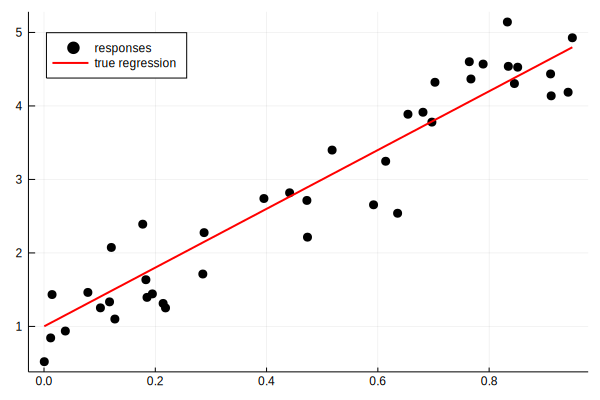

In [2]:
# Number of samples
N = 40

# Parameters
true_w = [4.0; 1.0]
true_σ = 1/2

function generate_data(true_w, true_σ; num_samples=10)
    "Generate data according to y = x⋅w + ϵ"
    
    # Covariates
    x = rand(Uniform(0,1), num_samples)
    
    # Linear function of covariates
    fx = x.* true_w[1] .+ true_w[2] 
    
    # Generate Gaussian noise
    ϵ = rand(Normal(0, true_σ), num_samples)
    
    # Responses consist of the linear mapping plus noise
    y = fx + ϵ
    
    # Return covariates and responses
    return y, x
end

# Generate data
responses, covariates = generate_data(true_w, true_σ, num_samples=N)

# True regression of the covariates
fx = covariates*true_w[1] .+ true_w[2]

# Visualize data
scatter(covariates, responses, color="black", label="responses", legend=:topleft)
plot!(covariates, fx, color="red", label="true regression", linewidth=2)

### Model specification

Turing has an intuitive means of specifying a model. It follows the math quite closely, and your final model will resemble a system of equations.

In [3]:
@model linear_regression(x, y, true_σ) = begin 
    
    # Extract number of samples
    num_samples = size(x, 1)
    
    # Weights prior parameters
    μ_w = [0.5; 0.]
    σ_w = 10*[1. 0.; 0. 1.]
    
    # Define a Gaussian prior distribution for the weights 
    w ~ MvNormal(μ_w, σ_w)

    # Loop over data points
    for i in 1:num_samples
        
        # Specify that responses are a Gaussian perturbation
        y[i] ~ Normal(x[i]*w[1] + w[2], true_σ) 
        
    end
end

# Call an instance of the model
model = linear_regression(covariates, responses, true_σ);

Now we are ready to infer the weights. For this problem setting, we will use [Hamiltonian Monte Carlo (HMC)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo). Don't worry too much about the details of the sampler. But if you are feeling adventurous, feel free to try out the other ones or try out different sampler parameter settings. Can you get better results? What happens to the runtime?

In [4]:
# Length of the chain
len_chain = 1000

# Define sampler 
sampler = HMC(0.01, 2)

# Construct a Markov chain and draw samples
chain = sample(model, sampler, len_chain);

The inference procedure has introduced a new object: the MCMCChain. It holds the samples as well as some diagnostic information to assess convergence of the sampler. Let's take a look.

In [5]:
describe(chain[:w])

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean    │ std      │ naive_se  │ mcse     │ ess     │
│     │ Symbol     │ Float64 │ Float64  │ Float64   │ Float64  │ Any     │
├─────┼────────────┼─────────┼──────────┼───────────┼──────────┼─────────┤
│ 1   │ w[1]       │ 3.38609 │ 1.05288  │ 0.0332951 │ 0.339623 │ 4.067   │
│ 2   │ w[2]       │ 1.17495 │ 0.428003 │ 0.0135347 │ 0.104505 │ 4.14387 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%   │ 75.0%   │ 97.5%   │
│     │ Symbol     │ Float64  │ Float64  │ Float64 │ Float64 │ Float64 │
├─────┼────────────┼──────────┼──────────┼─────────┼─────────┼─────────┤
│ 1   │ w[1]       │ 0.511372 │ 3.21131  │ 3.7144  │ 4.08112 │ 4.45556 │
│ 2   │ w[2]       │ 0.629856 │ 0.963757 │ 1.10514 │ 1.33554 │ 2.09391 │


The above table summarizes properties of the Markov chain. A lot of the entries are not important at the moment, so we will focus on the posterior distribution over the weights $w_1$ and $w_2$. Did the sampler succesfully manage to recover the parameters of the data generating process? 

We can also plot the chain. That will give us a visual clue of whether it has converged and what the approximate posterior looks like.

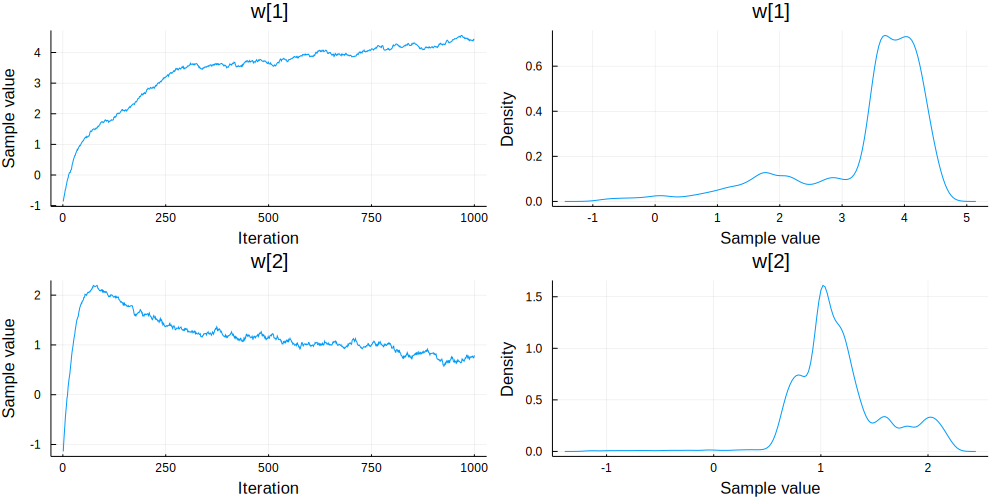

In [6]:
plot(chain[:w])

We can also make predictions using the expected value of the weight posterior.

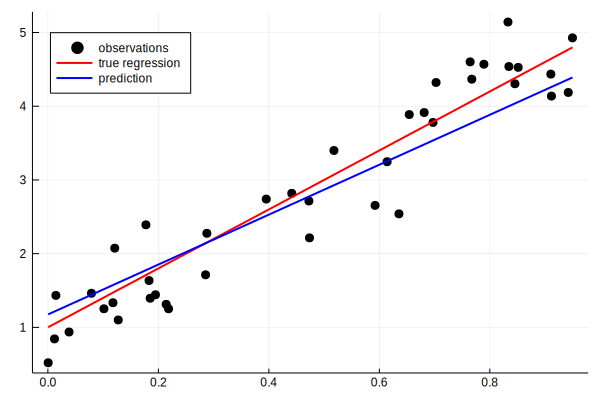

In [7]:
# Extract mean weights
w_hat = mean_chain(chain, :w)

# Make predictions
y_hat = covariates * w_hat[1] .+ w_hat[2]

# Visualize true data and observations
scatter(covariates, responses, color="black", label="observations", legend=:topleft)
plot!(covariates, fx, color="red", label="true regression", linewidth=2)

# Overlay predictions
plot!(covariates, y_hat, color="blue", label="prediction", linewidth=2)

Now it's your turn. Below are a few assignments to hone your skills with Probabilistic Programming in Turing.

## Classification

### Data generation
The code below generates a dataset of 0's and 1's. Your task is to turn the Turing model above into a binary classifier. The probabilistic model is:

$$ \begin{align} w \sim&\ \mathcal{N}(\mathbf{\mu_w},\mathbf{\sigma_w})\\
f(x) =&\ \sum_{d=1}^{D} x_d \cdot w_d + w_{D+1} \\
y \sim&\ \mathcal{B}er\big( \phi(f(x)) \big) \end{align} $$

As you can see, it is pretty similar to the linear regression covered so far. The main difference is that the likelihood function now consists of a logistic function $\phi$ that maps the output of $f(x)$ to the range [0,1] and a Bernoulli distribution describing the probability of y being 0 or 1. Convention dictates that we call $x$ "features" now and $y$ "labels".

In [8]:
# Logistic function
ϕ(x) = 1/ (1 + exp(-x));

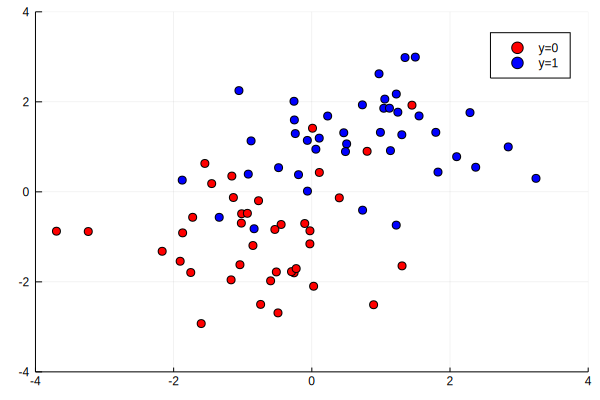

In [9]:
# Number of samples
num_samples = 80

# Parameters for generating data
true_w = [1.0, 1.0, 0.5]

function generate_binary_data(true_w; num_samples=10)
    "Generate two clusters of points stochastically separated by a linear function"
    
    # Divide the total number of samples over two clusters
    N1 = Integer(round(num_samples/2))
    N2 = Integer(num_samples - N1)
    
    # Generate data points from two clusters
    X1 = rand(MvNormal([-1., -1.], [1. 0.;0. 1.]), N1)
    X2 = rand(MvNormal([ 1.,  1.], [1. 0.;0. 1.]), N2)
    
    # Concatenate clusters
    X = [X1 X2]
    
    # Linear mapping of features
    fx = true_w[1:2]'*X .+ true_w[3]
    
    # Allocate label vector
    y = zeros(num_samples,)
    
    # Loop over data points
    for n = 1:num_samples
        
        # Generate observation y for each data point x
        y[n] = rand(Bernoulli(ϕ(fx[n])), 1)[1]
        
    end
    
    return y, X
end

# Binary dataset
labels, features = generate_binary_data(true_w, num_samples=num_samples)

# Visualize data
scatter(features[1, labels .== 0], features[2, labels .== 0], color="red", label="y=0", xlims=(-4,4), ylims=(-4,4))
scatter!(features[1, labels .== 1], features[2, labels .== 1], color="blue", label="y=1", xlims=(-4,4), ylims=(-4,4))

### Model specification

Specifying a logistic regression model is straightforward in Turing.jl.

In [10]:
using LinearAlgebra: I

@model logistic_regression(X, y) = begin
        
    # Extract number of samples
    num_samples = size(X, 2)
        
    # Check number of parameters necessary
    dim = size(X,1)+1
    
    # Weights prior parameters
    μ_w = zeros(dim,)
    σ_w = Matrix{Float64}(I, dim, dim)
    
    # Weight prior
    w ~ MvNormal(μ_w, σ_w)

    # Loop over data points
    for i in 1:num_samples
        
        # Likelihood
        y[i] ~ Bernoulli(ϕ(w[1:end-1]'*X[:,i] .+ w[end]))
        
    end
end;

We can use the same sampler as for linear regression.

In [11]:
# Length of the chain
len_chain = 1000

# Define sampler 
sampler = HMC(0.05, 10)

# Model
model = logistic_regression(features, labels)

# Start sampling
chain = sample(model, sampler, len_chain);

Let's take a look at the chain.

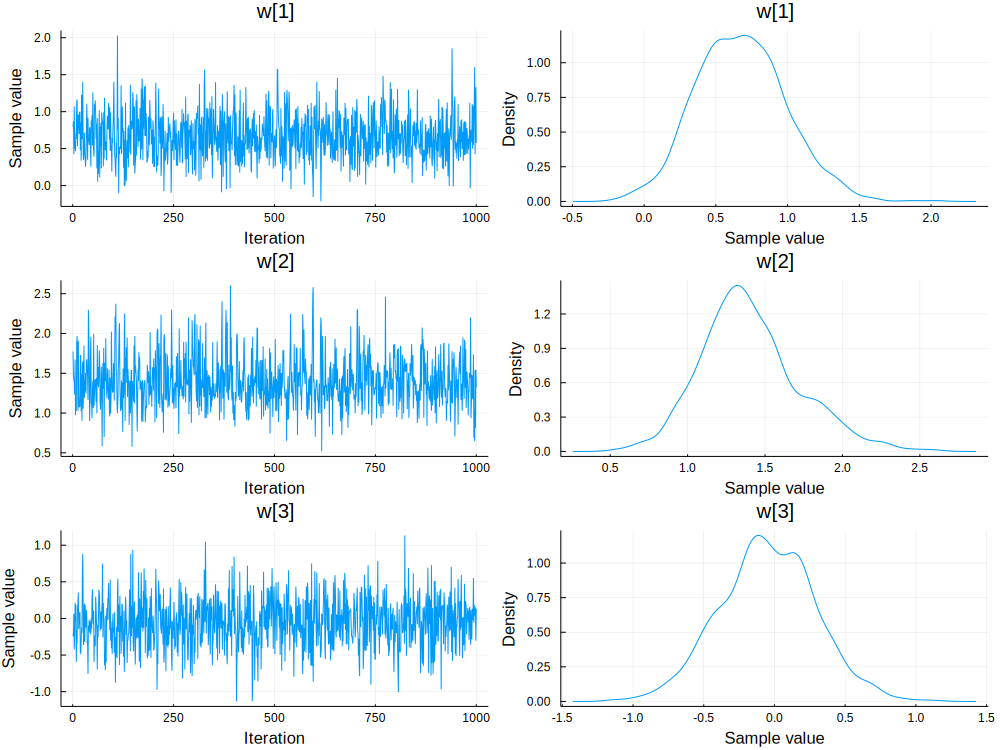

In [12]:
plot(chain[:w])

Let's also have a look at the resulting decision boundary.

In [13]:
# Visualize data
scatter(features[1, labels .== 0], features[2, labels .== 0], color="red", label="y=0", xlims=(-4,4), ylims=(-4,4))
scatter!(features[1, labels .== 1], features[2, labels .== 1], color="blue", label="y=1", xlims=(-4,4), ylims=(-4,4))

# Visualize true boundary
plot_decisionboundary(true_w, color="green", label="true")

# Visualize estimated boundary
weights = mean_chain(chain, :w)
plot_decisionboundary(weights, color="black", label="estimated")

How accurate is that?

In [14]:
# Extract estimated weights
weights_estimated = mean_chain(chain, :w)

# Map features
fx = weights_estimated[1:end-1]'*features .+ weights_estimated[end]

# Apply logistic function and check which side of 0.5 the result falls on
labels_estimated = round.(ϕ.(fx))

# Count the number of errors
accuracy = mean(labels_estimated .== labels')

0.85

### Assignment: Markov chain convergence

[MCMCChains.jl](https://github.com/TuringLang/MCMCChains.jl) has a number of functions to help you examine your chain's convergence. They are called Diagnostics, in particular you should have a look at the Geweke and the Heidelberg-Welch diagnostic.

1. Geweke takes the first part (0-10%) and the last part of the chain (50-100%), computes means and performs a hypothesis test to see if they are equal. If the chain has converged, the means will be roughly equal. If it has not converged, they will deviate beyond what you might expect.


2. Heidelberg-Welch performs a hypothesis test to see if the chain drifts ([Cramer-von Mises](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93von_Mises_criterion)). If it tests negative, it discards the first 10% of samples and repeats the procedure. If 50% has to be discarded, then the chain is deemed non-stationary and you need to run it for a longer period.

Both are hypothesis tests with null hypotheses stating that the chain is stationary. That means that the smaller the p-value, the more you might believe that the chain is not stationary.

Run a diagnostic function on chain[:w] and interpet the result. Has your chain converged?

In [ ]:
### Your code here

### Optional assignment: real data
Download the Titanic dataset from https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv. It contains passenger information of the Titanic. Build a classifier that predicts whether a passenger survives or not, based on the available information. You will have to do your own data wrangling to get the data set into the right shape (hint: Julia packages [CSV.jl](https://juliadata.github.io/CSV.jl/stable/) and [DataFrames.jl](https://juliadata.github.io/DataFrames.jl/stable/), use dfcol_str2int(::DataFrame, ::column_symbol) for converting string columns to numbers), as well as come up with your own model specification and parameterisation.

In [ ]:
### Your code here